In [21]:
pip install umap-learn


[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [12]:
 # Step 1: Import libraries
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import umap
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Load dataset
df = pd.read_csv("../data/cleaned_github_users.csv")

# Step 3: Preprocess 'Languages' column
df['Languages'] = df['Languages'].fillna('Unknown')
df['Language_List'] = df['Languages'].apply(lambda x: [lang.strip() for lang in x.split(",")])

mlb = MultiLabelBinarizer()
lang_encoded = mlb.fit_transform(df['Language_List'])

# Step 4: Apply UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='jaccard', random_state=42)
embedding = reducer.fit_transform(lang_encoded)

# Step 5: Drop any NaNs from UMAP output
embedding_df = pd.DataFrame(embedding, columns=["UMAP_X", "UMAP_Y"])
embedding_df = embedding_df.dropna()

# Step 6: Re-align df with cleaned embedding (optional but recommended)
df_cleaned = df.loc[embedding_df.index].reset_index(drop=True)
embedding_df = embedding_df.reset_index(drop=True)

# Step 7: Apply DBSCAN
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=0.3, min_samples=5, metric='euclidean')
labels = clustering.fit_predict(embedding_df)

# Step 8: Add cluster labels
df_cleaned['UMAP_X'] = embedding_df['UMAP_X']
df_cleaned['UMAP_Y'] = embedding_df['UMAP_Y']
df_cleaned['Cluster'] = labels



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pynndescent/pynndescent_.py:939: UserWarning: Failed to correctly find n_neighbors for some samples. Results may be less than ideal. Try re-running with different parameters.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/s

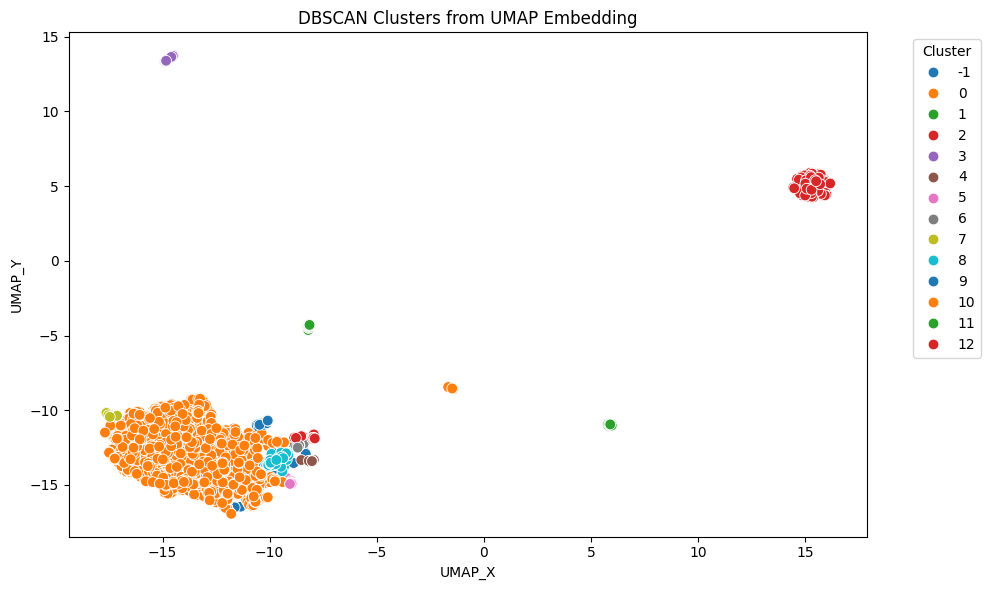

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='UMAP_X',
    y='UMAP_Y',
    hue='Cluster',
    data=df_cleaned,
    palette='tab10',
    s=60
)
plt.title("DBSCAN Clusters from UMAP Embedding")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [14]:
# Show top repositories per cluster
for cluster_id in sorted(df_cleaned['Cluster'].unique()):
    print(f"\n🔍 Cluster {cluster_id} - Top Repositories:")
    subset = df_cleaned[df_cleaned['Cluster'] == cluster_id]
    repo_list = subset['Repositories'].dropna().str.split(', ').explode()
    top_repos = repo_list.value_counts().head(5)
    print(top_repos)



🔍 Cluster -1 - Top Repositories:
Repositories
Magento-Two-factor-Authentication    1
expunge.io                           1
cucumber                             1
CS193P                               1
council_map                          1
Name: count, dtype: int64

🔍 Cluster 0 - Top Repositories:
Repositories
dotfiles    666
homebrew    144
docs        113
rails       107
bundler     105
Name: count, dtype: int64

🔍 Cluster 1 - Top Repositories:
Repositories
active_merchant    6
rails              6
authlogic          3
paperclip          3
i18n               3
Name: count, dtype: int64

🔍 Cluster 2 - Top Repositories:
Repositories
Unknown                      441
tree                           2
install-sql-server-action      2
pandas-decimal                 2
Gravityforms-es_ES             2
Name: count, dtype: int64

🔍 Cluster 3 - Top Repositories:
Repositories
attachment_fu    3
sample_app       3
demo_app         2
first_app        2
prawn            2
Name: count, dtype: int64

In [15]:
# Define domain tags
cluster_domains = {
    0: "DevOps",
    1: "Web Dev (Ruby)",
    2: "Sparse",
    3: "Web Dev",
    4: "Misc",
    5: "Web Dev (Ruby)",
    6: "Systems",
    7: "Infrastructure",
    8: "Generalist",
    9: "Web Dev (Ruby)",
    10: "Misc",
    11: "Ripple Projects",
    12: "Game Dev"
}

# Assign domain
df_cleaned['Domain_Tag'] = df_cleaned['Cluster'].map(cluster_domains)

df_cleaned.to_csv("../data/clustered_users_with_domains.csv", index=False)



In [16]:
def recommend_with_filters(username, preferred_location=None, preferred_domain=None, top_k=5):
    if username not in hybrid_df['Username'].values:
        print("❌ Username not found.")
        return pd.DataFrame()

    recs = hybrid_df_sorted[hybrid_df_sorted['Username'] != username].copy()

    if preferred_location:
        recs = recs[recs['Location'].str.contains(preferred_location, case=False, na=False)]

    if preferred_domain:
        recs = recs[recs['Domain_Tag'] == preferred_domain]

    return recs[['Username', 'Languages', 'Location', 'Profile_URL', 'Domain_Tag', 'hybrid_score', 'explanation']].head(top_k)


/var/folders/wv/nmvg2kvx7ns_8xhm99sdtmfm0000gn/T/ipykernel_15636/3404076899.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=domain_counts.index, y=domain_counts.values, palette="viridis")


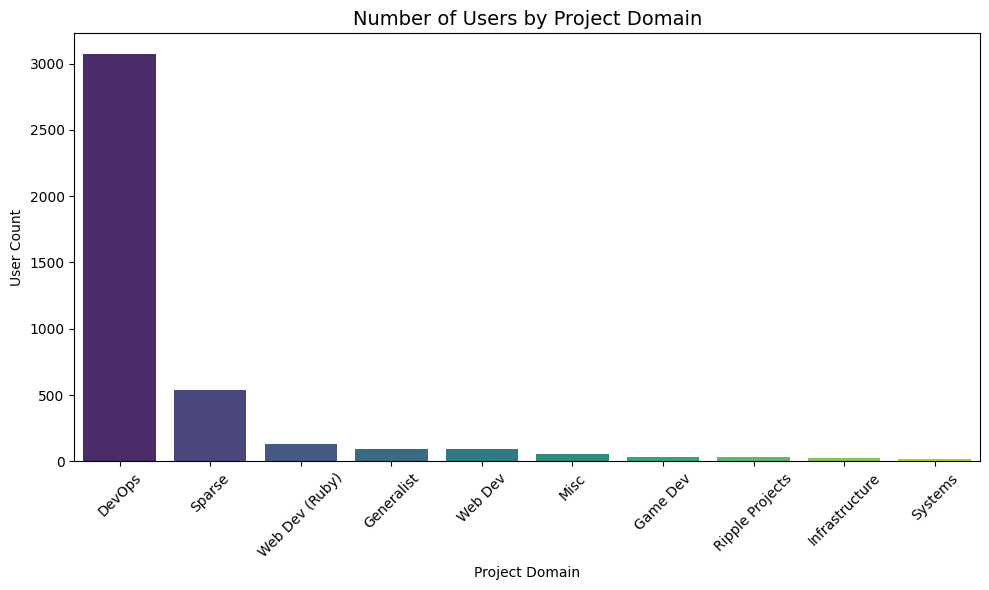

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count number of users in each domain
domain_counts = df_cleaned['Domain_Tag'].value_counts()

# Bar Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=domain_counts.index, y=domain_counts.values, palette="viridis")
plt.title("Number of Users by Project Domain", fontsize=14)
plt.ylabel("User Count")
plt.xlabel("Project Domain")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


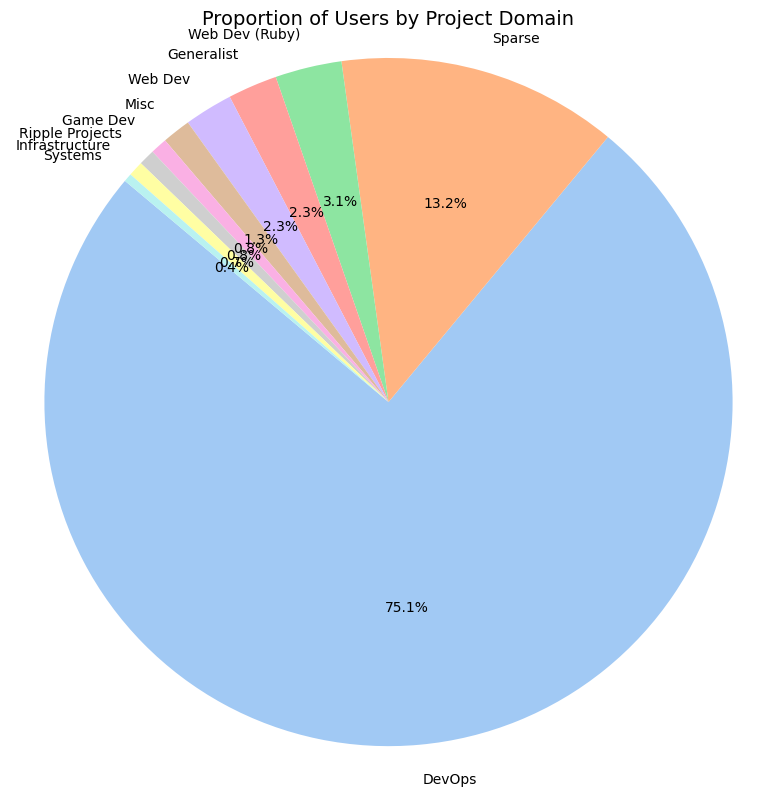

In [18]:
# Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(domain_counts.values, labels=domain_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title("Proportion of Users by Project Domain", fontsize=14)
plt.axis('equal')
plt.tight_layout()
plt.show()


In [31]:
!pip3 install optuna


[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [32]:
import optuna
import pandas as pd
import numpy as np
import umap
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Load the cleaned GitHub users dataset
df = pd.read_csv("../data/cleaned_github_users.csv")  # replace with your actual dataset path

# Select and preprocess numerical features
features = df[['Followers', 'Following', 'Public_Repos']].fillna(0)
features_scaled = StandardScaler().fit_transform(features)

# Optuna objective function
def objective(trial):
    # UMAP hyperparameters
    n_neighbors = trial.suggest_int('n_neighbors', 5, 100)
    min_dist = trial.suggest_float('min_dist', 0.0, 0.8)

    # DBSCAN hyperparameters
    eps = trial.suggest_float('eps', 0.1, 1.0)
    min_samples = trial.suggest_int('min_samples', 3, 15)

    # Apply UMAP
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2, random_state=42)
    embedding = reducer.fit_transform(features_scaled)

    # Apply DBSCAN
    clusterer = DBSCAN(eps=eps, min_samples=min_samples)
    labels = clusterer.fit_predict(embedding)

    # Filter valid clusters only
    valid_indices = labels != -1
    if len(set(labels[valid_indices])) < 2:
        return -1.0  # Invalid clustering for silhouette score

    # Calculate silhouette score
    score = silhouette_score(embedding[valid_indices], labels[valid_indices])
    return score

# Run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Show the best parameters and score
print(f"✅ Best Silhouette Score: {study.best_value:.3f}")
print(f"✅ Best Parameters: {study.best_params}")


[I 2025-05-16 02:07:50,060] A new study created in memory with name: no-name-73077883-b54f-4d9a-b1f8-816203c49d3d
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
[I 2025-05-16 02:07:59,313] Trial 0 finished with value: 0.6234432458877563 and parameters: {'n_neighbors': 64, 'min_dist': 0.13545559091391973, 'eps': 0.21920041018182354, 'min_samples': 14}. Best is trial 0 with value: 0.6234432458877563.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be re

✅ Best Silhouette Score: 0.947
✅ Best Parameters: {'n_neighbors': 12, 'min_dist': 0.0033954920303491953, 'eps': 0.10011331254767679, 'min_samples': 13}


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/wv/nmvg2kvx7ns_8xhm99sdtmfm0000gn/T/ipykernel_15636/4171253743.py:35: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


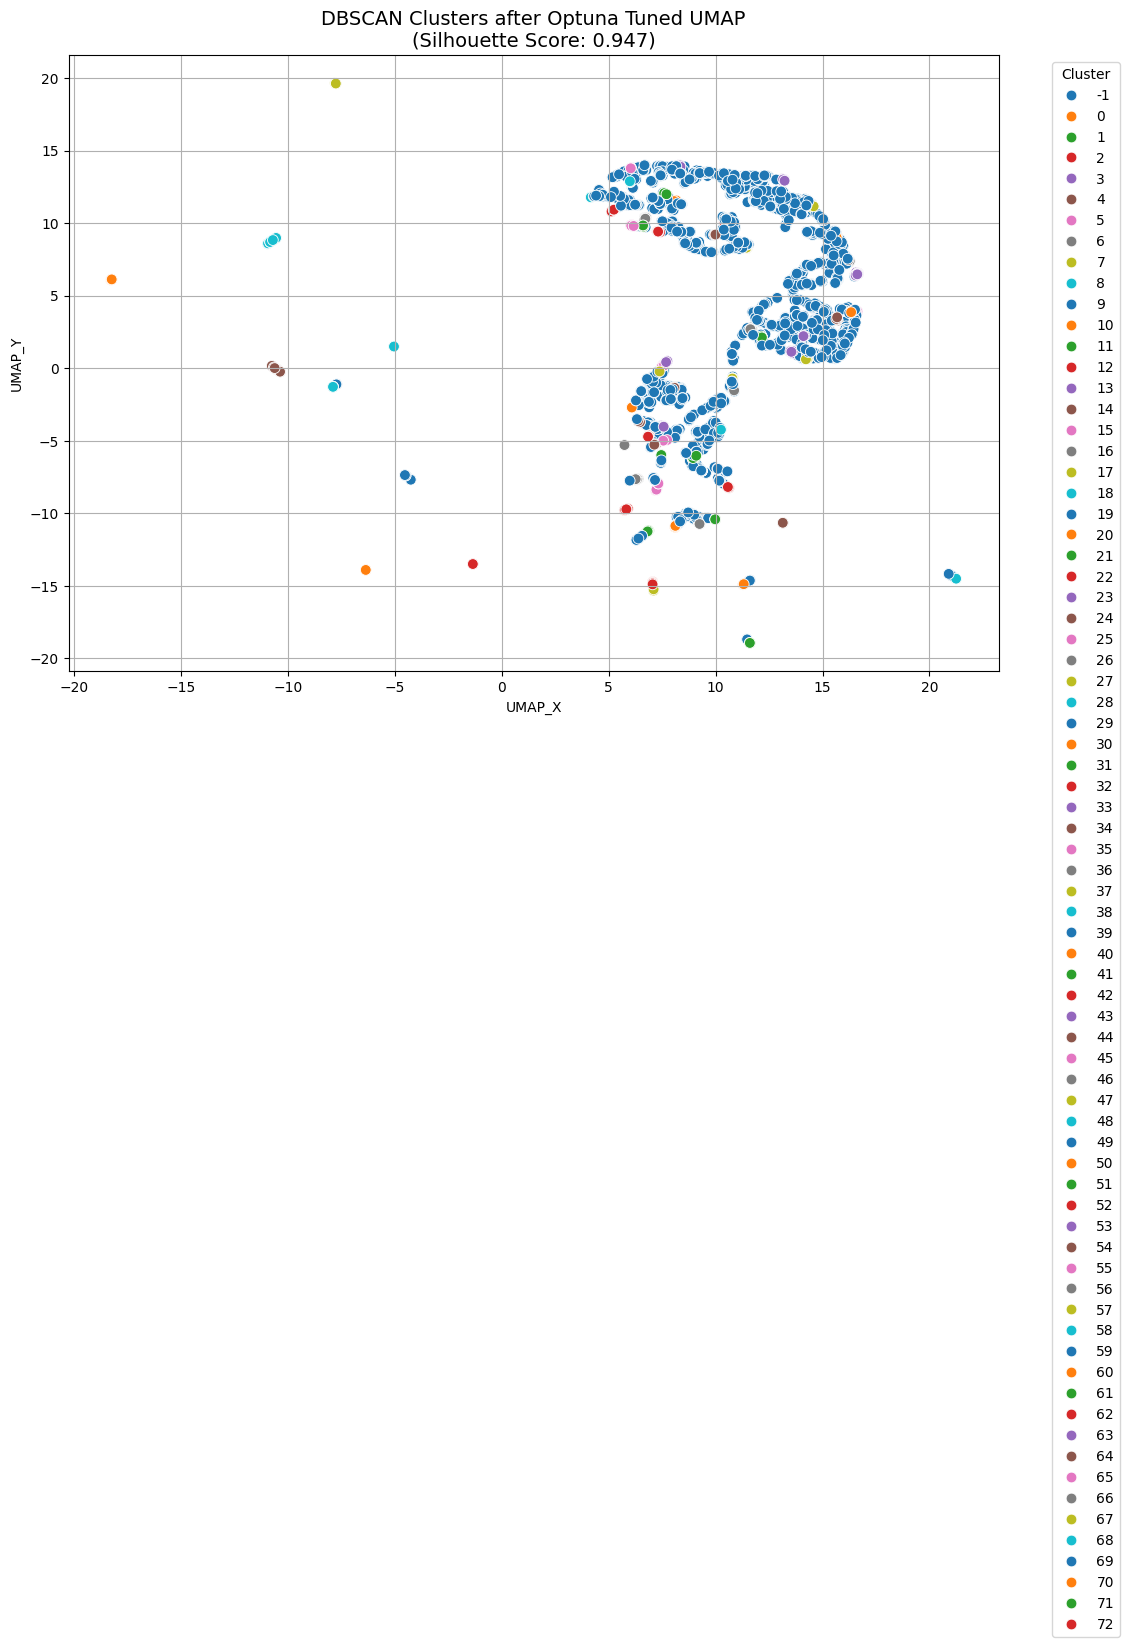

{-1: Repositories
 dotfiles    543
 homebrew    121
 docs         94
 bundler      89
 rails        88
 Name: count, dtype: int64,
 0: Repositories
 dotfiles          5
 bundler           3
 Adv360-Pro-ZMK    2
 disque-rb         2
 elm-core          2
 Name: count, dtype: int64,
 1: Repositories
 ai-deadlines             1
 test-blog                1
 phrakture.github.io      1
 lerna                    1
 jquery.pagevisibility    1
 Name: count, dtype: int64,
 2: Repositories
 test         1
 test1        1
 ber-model    1
 zombieurl    1
 gels         1
 Name: count, dtype: int64,
 3: Repositories
 dotfiles           8
 active_merchant    5
 discourse          4
 docker             3
 dotfiles-1         3
 Name: count, dtype: int64,
 4: Repositories
 dotfiles           6
 badges             3
 50marches          2
 nsecbunkerd        2
 nos-flutterflow    2
 Name: count, dtype: int64,
 5: Repositories
 authlogic                        4
 accord                           2
 CS410-16 

In [33]:
import pandas as pd
import umap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Load data
df = pd.read_csv("../data/cleaned_github_users.csv")  # replace with your path

# Feature preparation
features = df[['Followers', 'Following', 'Public_Repos']].fillna(0)
features_scaled = StandardScaler().fit_transform(features)

# Apply UMAP with best parameters
reducer = umap.UMAP(n_neighbors=12, min_dist=0.0034, n_components=2, random_state=42)
embedding = reducer.fit_transform(features_scaled)

# Apply DBSCAN with best parameters
clusterer = DBSCAN(eps=0.1001, min_samples=13)
labels = clusterer.fit_predict(embedding)

# Save results to dataframe
df['UMAP_X'] = embedding[:, 0]
df['UMAP_Y'] = embedding[:, 1]
df['Cluster'] = labels

# Plot clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='UMAP_X', y='UMAP_Y', hue='Cluster', data=df, palette='tab10', s=60)
plt.title(f"DBSCAN Clusters after Optuna Tuned UMAP\n(Silhouette Score: 0.947)", fontsize=14)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Generate Top Repositories per Cluster (Domain summary)
cluster_summary = {}
for cluster_id in sorted(df['Cluster'].unique()):
    subset = df[df['Cluster'] == cluster_id]
    repo_list = subset['Repositories'].dropna().str.split(', ').explode()
    top_repos = repo_list.value_counts().head(5)
    cluster_summary[cluster_id] = top_repos

cluster_summary


In [38]:
def assign_domain_tags(cluster_summary):
    domain_mapping = {}
    
    for cluster_id, top_repos in cluster_summary.items():
        repos_str = " ".join(top_repos.index.tolist()).lower()

        # Explicit rule for noise cluster (-1)
        if cluster_id == -1:
            domain = 'Unknown / Sparse Users'
        elif 'dotfiles' in repos_str or 'homebrew' in repos_str:
            domain = 'DevOps & Scripting'
        elif 'rails' in repos_str or 'active_merchant' in repos_str:
            domain = 'Ruby & Web Dev'
        elif 'ripple' in repos_str or 'ripplesite' in repos_str:
            domain = 'Blockchain & Ripple Projects'
        elif 'app-appwrite' in repos_str or 'mern' in repos_str:
            domain = 'MERN & Node.js Dev'
        elif 'test' in repos_str or 'sample_app' in repos_str:
            domain = 'Testing & Beginners'
        elif 'doom-emacs' in repos_str or 'xcode-calc' in repos_str:
            domain = 'Game & Modding'
        elif 'docker' in repos_str or 'chef' in repos_str:
            domain = 'Cloud & Infrastructure'
        else:
            domain = 'Misc / Other'

        domain_mapping[cluster_id] = domain

    return domain_mapping


In [35]:
# Apply the function to get domain mapping
domain_mapping = assign_domain_tags(cluster_summary)

# Map domain tags to your df
df['Domain_Tag'] = df['Cluster'].map(domain_mapping)

# Preview tagged clusters
df[['Username', 'Cluster', 'Domain_Tag']].head()


,Username,Cluster,Domain_Tag
0,mojombo,62,DevOps & Scripting
1,defunkt,62,DevOps & Scripting
2,pjhyett,-1,DevOps & Scripting
3,wycats,62,DevOps & Scripting
4,ezmobius,-1,DevOps & Scripting


In [36]:
# Create a clean report table
cluster_summary_report = []

for cluster_id, top_repos in cluster_summary.items():
    domain_tag = domain_mapping.get(cluster_id, 'Unknown')
    top_repos_list = ", ".join(top_repos.index.tolist())
    cluster_summary_report.append({
        'Cluster_ID': cluster_id,
        'Domain_Tag': domain_tag,
        'Top_Repositories': top_repos_list
    })

# Convert to DataFrame
df_cluster_summary_report = pd.DataFrame(cluster_summary_report)

# Show table
df_cluster_summary_report.head()


,Cluster_ID,Domain_Tag,Top_Repositories
0,-1,DevOps & Scripting,"dotfiles, homebrew, docs, bundler, rails"
1,0,DevOps & Scripting,"dotfiles, bundler, Adv360-Pro-ZMK, disque-rb, ..."
2,1,Testing & Beginners,"ai-deadlines, test-blog, phrakture.github.io, ..."
3,2,Testing & Beginners,"test, test1, ber-model, zombieurl, gels"
4,3,DevOps & Scripting,"dotfiles, active_merchant, discourse, docker, ..."


In [37]:
# Save the dataframe with cluster & domain tag
df.to_csv("../data/dbscan_optuna_clustered_users_with_domain.csv", index=False)

# Save the summary report as well
df_cluster_summary_report.to_csv("../data/dbscan_optuna_cluster_summary_report.csv", index=False)


In [39]:
# Get how many clusters were mapped to each domain tag
from collections import Counter

domain_cluster_count = Counter(domain_mapping.values())

# Display
for domain, count in domain_cluster_count.items():
    print(f"Domain Tag: {domain} | Number of Clusters: {count}")


Domain Tag: DevOps & Scripting | Number of Clusters: 32
Domain Tag: Testing & Beginners | Number of Clusters: 4
Domain Tag: Misc / Other | Number of Clusters: 23
Domain Tag: Game & Modding | Number of Clusters: 1
Domain Tag: Unknown / Sparse Users | Number of Clusters: 9
Domain Tag: MERN & Node.js Dev | Number of Clusters: 1
Domain Tag: Ruby & Web Dev | Number of Clusters: 3
Domain Tag: Blockchain & Ripple Projects | Number of Clusters: 1


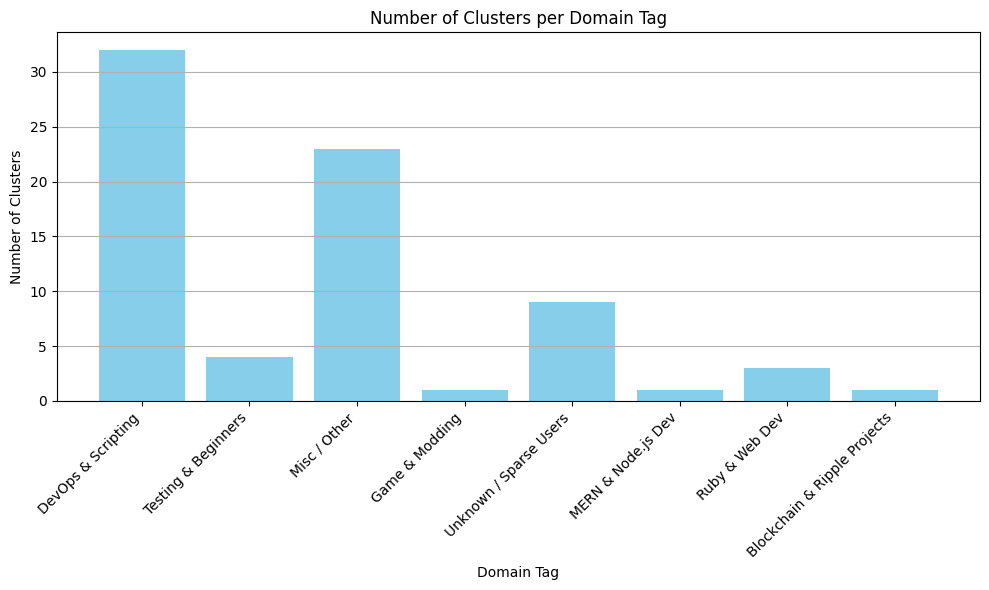

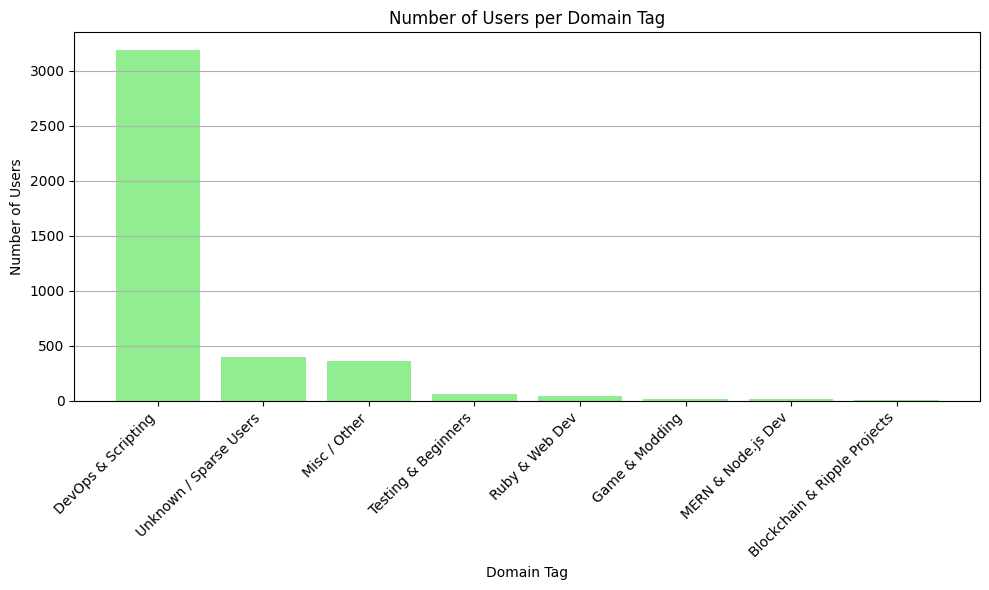

In [40]:
import matplotlib.pyplot as plt
from collections import Counter

# Recreate domain cluster count (ensure domain_mapping exists)
domain_cluster_count = Counter(domain_mapping.values())

# Bar chart: Number of Clusters per Domain Tag
plt.figure(figsize=(10, 6))
plt.bar(domain_cluster_count.keys(), domain_cluster_count.values(), color='skyblue')
plt.title('Number of Clusters per Domain Tag')
plt.xlabel('Domain Tag')
plt.ylabel('Number of Clusters')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Bar chart: Number of Users per Domain Tag (ensure df['Domain_Tag'] exists)
domain_user_count = df['Domain_Tag'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(domain_user_count.index, domain_user_count.values, color='lightgreen')
plt.title('Number of Users per Domain Tag')
plt.xlabel('Domain Tag')
plt.ylabel('Number of Users')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

